#### 10-7. 패션을 디자인하려면? 먼저 패션을 배워야지! (2) 코드로 살펴보기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from pathlib import Path
from keras.datasets import cifar10

# print("tensorflow", tf.__version__)

In [2]:
## cifar10 datasets
### 0 airplane
# 0 all
# 1 automobile
# 2 bird
# 3 cat
# 4 deer
# 5 dog
# 6 frog
# 7 horse
# 8 ship
# 9 truck

class_id_you_want = 9  

directory = Path.joinpath(Path.cwd(),'cifar10')

epoch_grahpic_dir = Path.joinpath(directory,'training_history','training_history_')

epoch_samples_dir = Path.joinpath(directory,'generated_samples', 'sample_epoch_')
epoch_samples_dir = str(epoch_samples_dir)

checkpoint_prefix = Path.joinpath(directory, 'training_checkpoints', "ckpt")

file_name = Path.joinpath(directory ,'generated_samples','sample*.png')
file_name = str(file_name)
    
anim_file = Path.joinpath(directory ,'cifar10_dcgan.gif')
anim_file = str(anim_file)


In [3]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(train_x, train_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [4]:
train_x, test_x = load_data(class_id_you_want)
train_x.shape

(5000, 32, 32, 3)

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


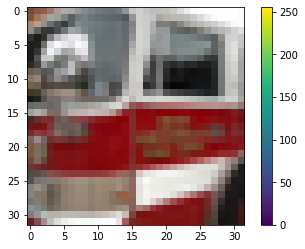

In [6]:
plt.imshow(train_x[20])
plt.colorbar()
plt.show()

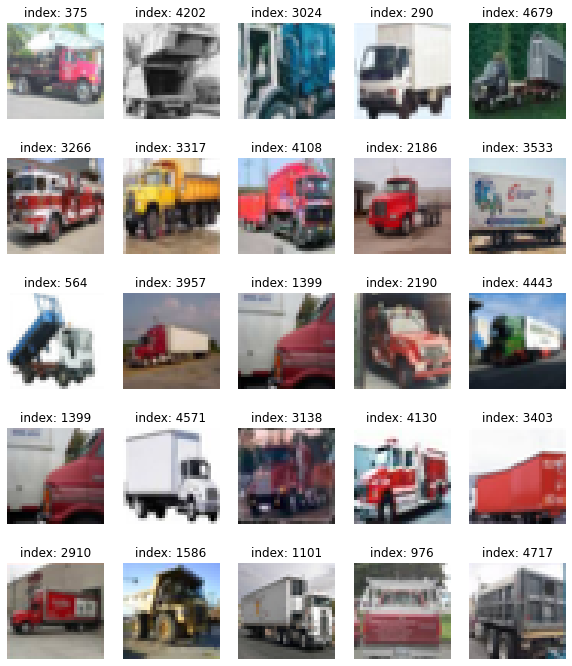

In [7]:
plt.figure(figsize=(10, 12))

for i in range(25):
    ran_index = np.random.randint(0, len(train_x))
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[ran_index])    
    plt.title(f'index: {ran_index}')
    plt.axis('off')
plt.show()

In [8]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [9]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(5000, 32, 32, 3)

In [10]:
BUFFER_SIZE = 2500
BATCH_SIZE = 480

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### 10-8. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (1) GAN 이해하기

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer    
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    

    # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,
#                                      activation='tanh'))
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False,
                                     activation='tanh'))


    return model


In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

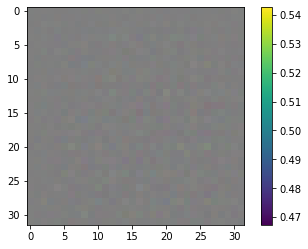

In [16]:
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')
pic = (np.array(generated_image) + 1) * 0.5
plt.imshow(pic[0, :, :, :])
plt.colorbar()
plt.show()

#### 10-10. 그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (3) 판별자 구현하기

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer    
#     model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))        
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))        
#     model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.3))
    model.add(layers.Dropout(0.1))
    
    # Second: Conv2D Layer
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))        
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))        
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2,2)))
#     model.add(layers.Dropout(0.3))
    model.add(layers.Dropout(0.2))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))    
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model


In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 re_lu (ReLU)                (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                    

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00971661]], dtype=float32)>

#### 10-11. 생성 모델이 똑똑해지기 위한 기나긴 여정 (1) 손실함수와 최적화 함수

In [20]:
# from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 
# 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_loss는 fake_output이 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교. 최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별자가 real output과 fake output을 accuracy 0.5 정도로 구별해내야 생성자와 판별자 둘다 잘하고 있다고 판단

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [24]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer     = tf.keras.optimizers.Adam(learning_rate=4e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성
        generated_images = generator(noise, training=True)  #(4) generated_images 생성 두번 교육

        #(5) discriminator 판별
        real_output = discriminator(images, training=True) 
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음

(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기

(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성

(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력

(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산

(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산

(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산

(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신

(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0], cmap='gray')
        pic = (np.array(predictions) + 1) * 0.5
        plt.imshow(pic[i, :, :, :])
        plt.axis('off')
   
#     plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
#                     .format(os.getenv('HOME'), epoch, it))
    plt.savefig('{}{:04d}_iter_{:03d}.png'
                    .format(epoch_samples_dir , epoch, it))

    plt.show()

# epoch = 10
# it = 10
# print('{}{:04d}_iter_{:03d}.png'
#                     .format(epoch_samples_dir , epoch, it))    

 loss와 accuracy 그래프를 빼놓을 수 없겠습니다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다. 
 train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 
 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
#     plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
#                     .format(os.getenv('HOME'), epoch))
    plt.savefig('{}{:04d}.png'
                    .format(epoch_grahpic_dir, epoch))

    plt.show()

# epoch = 10
# print('{}{:04d}.png'
#                     .format(epoch_grahpic_dir, epoch))    

In [29]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
def train(dataset, epochs, save_every):
#     start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
#         epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
#                 print('Epoch {} | iter {}'.format(epoch+1, it+1))
#                 print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
#         print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
# tf.config.list_physical_devices("GPU")

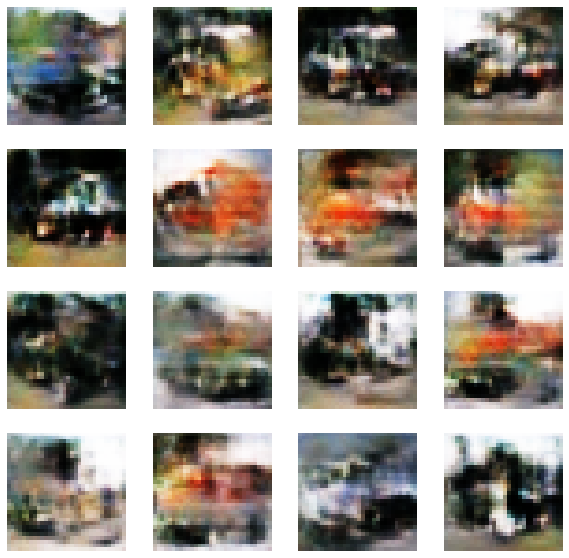

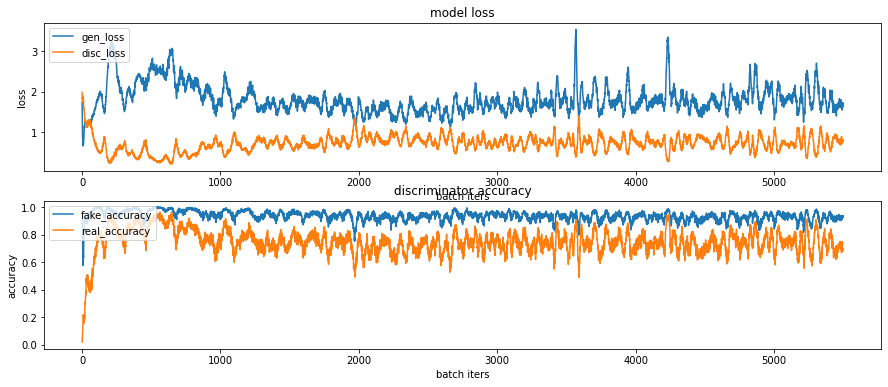

In [32]:
# %%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [33]:
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(file_name)
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)


#### 후 기  

교육이 진행되면서 사용되는 데이터의 색과 모양이 변하게 되는데 generator가 내놓는 그림도 따라서 변한다.
  
generator와 discriminator가 경쟁하면서 성능이 좋아지려면 learning_rate와  교육 횟수를 조절하는게 필요하다.  
  
generator와 discriminator의 구조에 따라서 이미지 품질이 달라진다.  
  
  

참고: https://github.com/4thgen/DCGAN-CIFAR10

### 1 epoch당 교육 횟수에 따른 학습곡선과 마지막에 출력된 이미지 비교 

#### 이미지 비교  
  
#### 한번씩만 
  
![one_time.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/one_time.png)
  
#### discriminator 두번  
  
![discriminator_two_time.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/discriminator_two_time.png)
  
#### generator 두번
  
![generator_two_time.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/generator_two_time.png)

### 학습곡선 비교

  
#### 한번씩만 
  
![one_time_1.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/one_time_1.png)
  
#### discriminator 두번  
  
![discriminator_two_time_1.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/discriminator_two_time_1.png)
  
#### generator 두번
  
![generator_two_time_1.png](https://raw.githubusercontent.com/Kona-cfd/AIFFEL_PROJECT/main/generator_two_time_1.png)